# Z-тест:

- Заказал $\alpha, \beta, MDE$, нашел нужное $n$ 
- Подержал АБ-тест так, чтобы накопилось $n$ наблюдений

- __Выборки:__

$$
\text{Независимые выборки} \\
X_1, \ldots, X_n \sim iid(\mu_C, \sigma^2_C) \\
Y_1, \ldots, Y_m \sim iid (\mu_T, \sigma^2_T) \\
$$

- __Гипотеза:__

$$
H_0 : \mu_T = \mu_C \\
H_a : \mu_T \ne \mu_C
$$

- __Критерий:__

$$
Z = \frac{\hat{\mu}_T - \hat{\mu}_C}{se(\hat{\mu}_T - \hat{\mu}_C)} \sim N(0,1)
$$

$$
se(\hat{\mu}_T - \hat{\mu}_C) = \sqrt{\frac{\hat{\sigma}^2_T}{m} + \frac{\hat{\sigma}^2_C}{n}} 
$$

Другой варик считать se() называется pooled: все наблюдения сваливаются в одну кучу и по ним считается одно общее se()

- Посчитал наблюдаемое значение статистики и сравнил его с критическим 
- Либо посчитал p-value и сравнил его с $\alpha$

**Предпосылки:**

- Нет выбросов (если они есть, тогда ломаются предпосылки ЦПТ и сходимости к нормальному может не быть)
- Большое $n$, биг дата, (иначе сходимости не будет и приближение нормальным будет работать плохо)
- Выборки независимы друг от друга и наблюдения не зависимы друг от друга

[Пример с NPS,](https://github.com/FUlyankin/yet_another_matstat_course/blob/main/notebooks/NPS_CI_simulation.ipynb) когда ломается предпосылка о независимости выборок и надо фиксить тест на ковариации

# Тест Уэлча

В $z$-статистике распределение асимптотическое, а в $t$-статистике точное. Но только если выборка одна! Если у нас есть две выбоорки, то всё разваливается! Точного распределения даже при нормальности выборок для разности средних не существует, [Behrens–Fisher problem](https://translated.turbopages.org/proxy_u/en-ru.ru.f8089dff-6440f903-acf6cf2b-74722d776562/https/en.wikipedia.org/wiki/Behrens–Fisher_problem)

Можно попытаться найти НЕ асимптотическое, а "приблизительное" распределение (Тест Уэлча):

$$
t = \frac{\hat{\mu}_T - \hat{\mu}_C}{se(\hat{\mu}_T - \hat{\mu}_C)} \approx t(\nu)
$$

$$
se(\hat{\mu}_T - \hat{\mu}_C) = \sqrt{\frac{s^2_T}{m} + \frac{s^2_C}{n}} 
$$


**Предпосылки:**

- Обе выборки нормально распределены 
- Все наблюдения независимы друг от друга

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sts

df = pd.read_csv('df_vk_wise.csv')
df.head()

,likes,reposts,text,I
0,7,0,Кому удобнее следить за новостями М. в инстагр...,False
1,575,25,"Если девушка невероятно хороша в юности, но ра...",False
2,509,57,"То была очень обычная узость мышления - те, кт...",False
3,542,15,"Когда он знакомил меня с Сергеем, тот спросил:...",False
4,949,59,"- Общепризнано, сэр, что физические упражнения...",False


2871.347265625 2773.369992383854
2580.5 2490.0


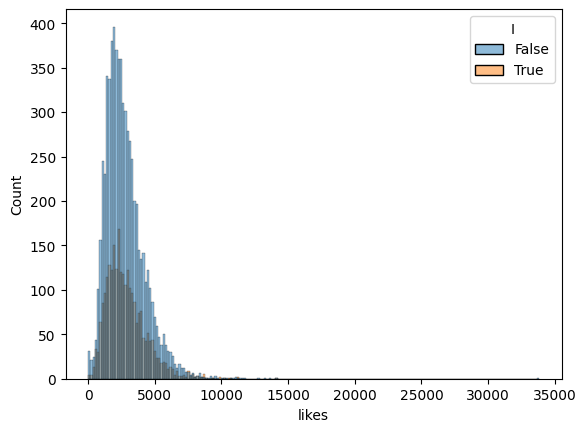

In [2]:
sns.histplot(df, x='likes', hue='I');
x = df[df.I].likes.values
y = df[~df.I].likes.values

# среднее от медианы сильно отличается 
# => выбросы! 
print(x.mean(), y.mean())
print(np.median(x), np.median(y))

118.521484375 112.34531607006855
96.0 93.0


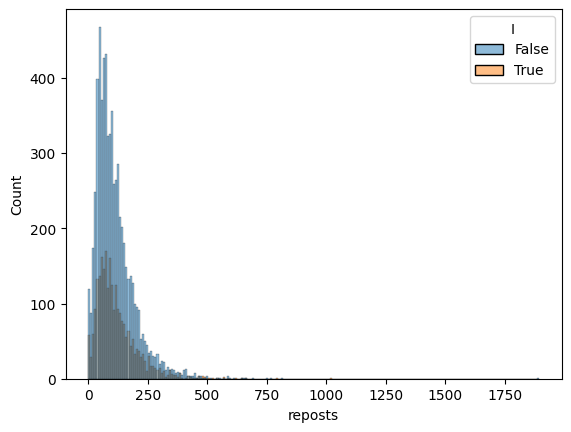

In [3]:
sns.histplot(df, x='reposts', hue='I');

x = df[df.I].reposts.values
y = df[~df.I].reposts.values

# среднее от медианы сильно отличается 
# => выбросы! 
print(x.mean(), y.mean())
print(np.median(x), np.median(y))

In [4]:
diff = x.mean() - y.mean() 
diff_std = np.sqrt(x.var(ddof=1)/x.size + y.var(ddof=1)/y.size)
z_obs = diff/diff_std
z_obs

3.047531998539413

In [7]:
alpha = 0.05
z_crit = sts.norm.ppf(1 - alpha/2)
pval = 2*sts.norm.cdf(-z_obs)
z_crit, pval

(1.959963984540054, 0.0018688830401119385)

__Выводы:__ На уровне значимости 5% гипотеза о равенстве среднего числа лайков отвергается. 

In [8]:
from statsmodels.stats.weightstats import ztest

z_obs, pval = ztest(x, y, value=0, alternative='two-sided', usevar='pooled', ddof=1.0)
z_obs, pval

(3.1103143997608775, 0.0018688830401119385)

In [9]:
# немного странноватый вариант из теста
ddof=1.0
var_pooled = x.size * x.var() + y.size * y.var()
var_pooled /= x.size + y.size - 2 * ddof
var_pooled *= 1.0 / x.size + 1.0 / y.size

diff/np.sqrt(var_pooled)

3.1103143997608775

Это параметрические тесты. Мы делаем свои предположения о параметрах распределения. В случае выше о математическом ожидании!

Из-за выбросов было бы прикольно рассуждать именно в терминах медиан, так как они к выбросам устойчивы. Но у нас нет параметрической техники для проверки гипотез о медианах.

# Бутстрап

Бутсрап - это асимптотическая техника получения критических значений. С помощью него можно проверять гипотезы практически о чём угодно. В том числе о медианах. 

Поговорим подробнее в следующий раз.

# Тест Манна-Уитни

Непараметрические тесты. Фишка этих тестов, что мы не думаем о параметрах распределений. Мы не думаем про математические ожидания. Мы формулируем все гипотезы о "форме" распределений. 

[Тетрадочка с чуть более подробным описанием](https://github.com/FUlyankin/matstat-AB/blob/main/week10_nonparam_bootstrap/08_python_non_parametric.ipynb)

Если забыли, то вот вам реклама лекций Фила: 

- [Видосы с курсеры](https://www.youtube.com/watch?v=2p24KPez62U&list=PLCf-cQCe1FRyCcf47wwBlDObNcz4ud2_L)
- [Лекция про непараметрические критерии из ФКНовской магистратуры](https://www.youtube.com/watch?v=0Rn6ImS0WK4)

In [10]:
from scipy.stats import mannwhitneyu

U, pval = mannwhitneyu(x, y, alternative='two-sided')
U

8736923.0

In [11]:
pval

0.0031580345232610444

In [12]:
U = 0
for item in y:
    for jtem in x:
        U += (item > jtem)
        U += 0.5*(item == jtem)
U

8069477.0

In [13]:
x.size*y.size - U

8736923.0

In [14]:
# Давайте попробуем сымитировать ситуацию, где тест Манна-Уитни развалится

In [15]:
n_obs = 1000
x = sts.norm(0, 4).rvs(n_obs)
y = sts.norm(1, 1).rvs(n_obs)

_, pval = mannwhitneyu(x, y, alternative='two-sided')
pval

5.920283674292367e-15

In [16]:
import matplotlib.pyplot as plt

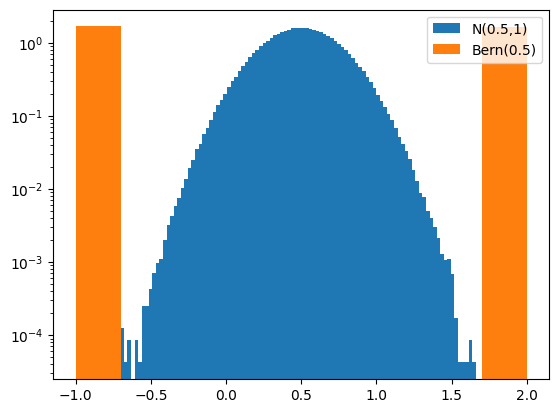

In [17]:
n_obs = 10**6
x = sts.norm(0.5, 0.25).rvs(n_obs)
y = 3*sts.bernoulli(0.5).rvs(n_obs) - 1

plt.hist(x, bins=100, density=True, label='N(0.5,1)');
plt.hist(y, density=True, label='Bern(0.5)', log=True);
plt.legend();

In [18]:
_, pval = mannwhitneyu(x, y, alternative='two-sided')
pval

0.32928060235916545